In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import os
import sqlite3
from scipy.optimize import curve_fit
from matplotlib.backends import backend_pdf

In [2]:
# SUPPORT FUNCTIONS TO CONVERT CHANNEL ID TO BOARD/PMT ID
# using hardware database inside icarus_data

def readSqlitedb(database="/cvmfs/icarus.opensciencegrid.org/products/icarus/icarus_data/v09_79_01/icarus_data/database/ChannelMapICARUS_20230829.db", table="pmt_placements_29aug2023"):

    # Read sqlite query results into a pandas DataFrame
    con = sqlite3.connect(database)
    df = pd.read_sql_query("SELECT * from {}".format(table), con)

    con.close()

    return df

def get_channel_id(db, board, digitizer_channel):
    
    ch = db.loc[(db['digitizer_label']==board) & (db['digitizer_ch_number']==digitizer_channel), ['channel_id']]
    # print(board, ",", digitizer_channel, "-->", ch.values[0][0])

    return ch.values[0][0]

def get_PMT_id(db, channels):
     
    if np.isscalar(channels):
        pmt_id = db[db.channel_id==channels].pmt_id.values[0]
        return pmt_id
    else:
        pmt_ids = [ db[db.channel_id==ch].pmt_id.values[0] for ch in channels ] 
        return pmt_ids
    
def get_channel_board(db, ch):
    
    board = db.loc[db['channel_id']==ch].digitizer_label.values[0]
    return board

In [3]:
# load data from all files for calibrations
# returns dict: DC offset vs dataframes with data

def loadfiles(rundb, basepath="../runs/"):
    data = {}
    for label, run in rundb.items():
        file = basepath + str(run) + "/measChannelBaselines_run" + str(run) + ".csv"
        df = pd.read_csv(file, sep=',')    
        data[label] = df
    return data

In [4]:
# checks if baselines is stable at the beginning of each run, for each channel, within expected fluctuations
# necessary to make sure it is okay to use the mean computed on the first events
# n: number of events
# eps: acceptable fluctuations

def check_baseline_stability(geodb, rundb, data, n=20, eps=10):
    
    issues = {}
    
    # for each run
    for lab, run in rundb.items():
    
        timestamps = data[lab]["timestamp"].to_numpy()
        time = [datetime.fromtimestamp(t).strftime('%H:%M') for t in timestamps]
        fig = plt.figure()
        c = []
        
        #for each channel
        for ch in range(360):
            
            col = "baseline_ch" + str(ch)
            label_name = "Ch " + str(ch)
            baselines = data[lab][col].head(n).to_numpy()
            
            #check fluctuations
            if np.std(baselines) > eps:
                print("Warning: Run " + run + ", Ch " + str(ch) + ", board " + get_channel_board(geodb,ch) + ": instable baseline!")
                plt.plot(time,data[lab][col],label=label_name)
                c.append(ch)
        
        if fig.get_axes():
            plt.title(run)
            plt.xlabel("Time")
            plt.ylabel("Baseline [ADC]")
            plt.setp(plt.gca().get_xticklabels(), rotation=60, ha="right")
            plt.tight_layout()
            plt.grid()
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plt.show()
            issues[offset] = c
            
    return issues

In [5]:
# checks stability of using the median to compute the baseline at start
# only for channels that have shown to be instable!
# n: number of events

def check_median_stability(issues, rundb, data, n=20):
    
    for lab in issues.keys():
        
        run = rundb[lab]
        channels = issues[lab]
        print("Run " + run + ", pedestal " + str(lab) + ": " + str(len(channels)) + " channels")
        fig = plt.figure(figsize=(18,40))
        fig.subplots_adjust(hspace=0.4, wspace=0.4)
        
        i = 0
        for ch in channels:
            
            col = "baseline_ch" + str(ch)
            baselines = data[lab][col].head(n).to_numpy()
            median = np.median(baselines)
            i = i+1
            ax = plt.subplot(len(channels),4,i)
            ax.hist(baselines, bins=50, range=(np.amin(baselines)-10,np.amax(baselines)+10), histtype='bar', lw=2, label="Mean: {:.1f}\nStd: {:.1f}".format(np.mean(baselines),np.std(baselines)))
            ax.axvline(x=median, color="red", linestyle='dotted')
            ax.legend()
            ax.set_title(col)
        
        #fig.supxlabel("Baseline [ADC]",fontsize=16)
        plt.show()

In [6]:
def get_channel_data(ch, data, n=20, minerr=20.0):
    
    bs = []
    err = []
    col = "baseline_ch" + str(ch)
    offsets = []
    
    for label, df in data.items():
        baselines = df[col].head(n).to_numpy()
        bs.append(np.median(baselines))
        rms = np.sqrt( np.square(np.subtract(baselines,np.median(baselines))).mean())
        if rms < minerr: rms = minerr
        err.append(rms)
        
        offfile = "baseline_scans/DC_offsets_{}.csv".format(label)
        df2 = pd.read_csv(offfile,sep=',')
        dc_offset = df2[df2.channel_id==ch].DC_offset.values[0]
        offsets.append(dc_offset)

    return offsets, bs, err

def line(x,a,b):
    return a*x+b

In [7]:
def extrapolate_line(bs_target, a, err_a, b, err_b):
    
    dacnom = (bs_target-b)/a
    
    dxdb = -1./a
    dxda = (b-bs_target)/(a**2)
    
    edacnom = np.sqrt( (dxdb*err_b)**2 + (dxda*err_a)**2 )
    
    return dacnom, edacnom

In [8]:
def dofit( dcoffset, baseline, error_baseline, bs_target = 14747):
    
    a0 = (baseline[1]-baseline[0])/(dcoffset[1]-dcoffset[0])
    b0 = baseline[0]
    
    params, pcov = curve_fit(line, dcoffset, baseline, sigma=error_baseline, absolute_sigma=True, p0=(a0,b0))
            
    stderr = np.sqrt(np.diag(pcov))
    
    xint = np.linspace( np.min(dcoffset)-10, np.max(dcoffset)+10, 1000 )
    yint = line(xint, params[0], params[1])
    
    dacnom, edacnom= extrapolate_line( bs_target, params[0], stderr[0] , params[1], stderr[1] )
    
    return params, stderr, xint, yint, dacnom, edacnom

# Baseline calibration

In [27]:
rundb = { "nom":10927, "p5":10923, "m5":10924,  "p10":10926, "m10":10925,}# "m20":10929 }
geodb = readSqlitedb()

data = loadfiles(rundb, basepath="../runs/")

In [28]:
issues = check_baseline_stability(geodb, rundb, data, n=500)
#print(issues.items())

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [29]:
check_median_stability(issues, rundb, data, n=500)

In [30]:
data["m10"].head()

,event,timestamp,baseline_ch0,baseline_ch1,baseline_ch2,baseline_ch3,baseline_ch4,baseline_ch5,baseline_ch6,baseline_ch7,...,baseline_ch350,baseline_ch351,baseline_ch352,baseline_ch353,baseline_ch354,baseline_ch355,baseline_ch356,baseline_ch357,baseline_ch358,baseline_ch359
0,4,1698109206,14920,15006,14917,14947,14916,14923,14924,14893,...,14921,14922,14936,14936,14920,14931,14933,14914,14943,14913
1,8,1698109207,14918,15006,14917,14947,14917,14923,14923,14894,...,14920,14921,14935,14936,14919,14932,14933,14913,14943,14911
2,12,1698109207,14919,15006,14917,14948,14916,14923,14924,14893,...,14920,14921,14935,14936,14920,14932,14934,14914,14944,14912
3,16,1698109207,14919,15007,14917,14948,14916,14924,14925,14894,...,14920,14922,14936,14934,14920,14931,14932,14914,14942,14913
4,20,1698109208,14919,15007,14917,14948,14916,14923,14925,14894,...,14921,14921,14935,14936,14920,14932,14934,14914,14944,14914


### Plot one channel

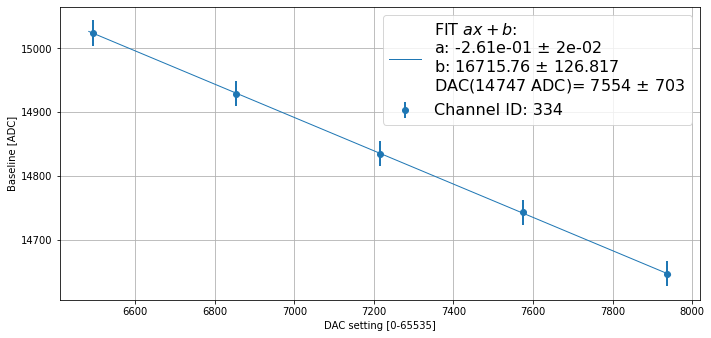

In [31]:
channel_id = 334
dac, bs, err = get_channel_data(channel_id, data, n=20)
target = 14747

fig, ax = plt.subplots(1,1, figsize=(10, 4.8))
kargs={'marker':'o', 'lw':0.0, 'elinewidth':2.0}
    
out=plt.errorbar( x=dac, y=bs, yerr=err, label=("Channel ID: %d" % channel_id), **kargs)
p, ep, xint, yint, dacnom, edacnom = dofit(dac, bs, err, bs_target=target)
            
label= "FIT $ax + b$: \n"
label+="a: %.2e $\pm$ %3.e\n" % ( p[0], ep[0] ) 
label+="b: %.2f $\pm$ %.3f\n" % ( p[1], ep[1] )
label+='DAC(%d ADC)= %d $\pm$ %d' % ( target, dacnom, edacnom )
            
plt.plot(xint, yint, color=out[0].get_color(), lw=1.0, label=label)
    
plt.xlabel("DAC setting [0-65535]")
plt.ylabel("Baseline [ADC]")
plt.legend(fontsize=16)
plt.grid()
    
fig.tight_layout()

### Plot everything

In [14]:
pdf = backend_pdf.PdfPages("calibrations/baseline_calibration_TEST.pdf")
target = 14747

calibration = []
DAC_nominal = []

for channel_id in range(0, 360):
            
    # Define the plot
    fig, ax = plt.subplots(1,1, figsize=(10, 4.8))
    kargs={'marker':'o', 'lw':0.0, 'elinewidth':2.0}

    #Fetch data
    dac, bs, ebs = get_channel_data(channel_id, data, n=20)
             
    out=ax.errorbar( x=dac, y=bs, yerr=ebs, label=("Channel ID: %d" % channel_id), **kargs )
    
    p, ep, xint, yint, dacnom, edacnom = dofit(dac, bs, ebs, bs_target=target)
   
    calibration.append( {"channel_id": channel_id, 
                    "p0": p[0], 
                    "ep0": ep[0], 
                    "p1": p[1], 
                    "ep1": ep[1], 
                   })
    
    DAC_nominal.append(dacnom)

    label= "FIT $ax + b$: \n"
    label+="a: %.2e $\pm$ %3.e\n" % ( p[0], ep[0] ) 
    label+="b: %.2f $\pm$ %.3f\n" % ( p[1], ep[1] )
    label+='DAC(%d ADC)= %d $\pm$ %d' % ( target, dacnom, edacnom )
            
    ax.plot(xint, yint, color=out[0].get_color(), lw=1.0, label=label)
    
    ax.set_xlabel("DAC setting [0-65535]")
    ax.set_ylabel("Baseline [ADC]")
    ax.legend(fontsize=16)
    
    fig.tight_layout()
    plt.grid()
    pdf.savefig( fig )
    
    plt.close()


pdf.close()

In [69]:
calibDB = pd.DataFrame(calibration)
calibDB.to_csv("calibrations/baseline_calibration_24Oct2023.csv",sep=',')

## Produce output files

### Write requested DC offset

In [15]:
print("Writing DC offsets to equalize baselines at " + str(target))

path = "calibrations/DC_offsets_for_"+str(target)+"_TEST.csv"
ofile = open(path,"w")
header = "channel_id,baseline,DC_offset\n"
ofile.write(header)

for channel_id in range(0,360):
    out = str(channel_id) + "," + str(target) + ","
    out += str(int(DAC_nominal[channel_id]))+"\n"
    ofile.write(out)
    
ofile.close()

Writing DC offsets to equalize baselines at 14747


In [74]:
old_nominal = pd.read_csv("baseline_scans/DC_offsets_nom.csv",sep=",")
new_nominal = pd.read_csv("calibrations/DC_offsets_for_"+str(target)+"_24Oct2023_calibrated.csv",sep=",")

new_nominal.rename(columns={'baseline':"baseline_new", "DC_offset":"DC_offset_new"}, inplace=True)
old_nominal = (old_nominal.join( new_nominal, on=["channel_id"], rsuffix="_new", how='inner'))

In [75]:
old_nominal.head()

,channel_id,baseline,DC_offset,channel_id_new,baseline_new,DC_offset_new
0,14,14747,7078,14,14747,6988
1,11,14747,6559,11,14747,6479
2,4,14747,7236,4,14747,7169
3,1,14747,7019,1,14747,7329
4,7,14747,6829,7,14747,6723


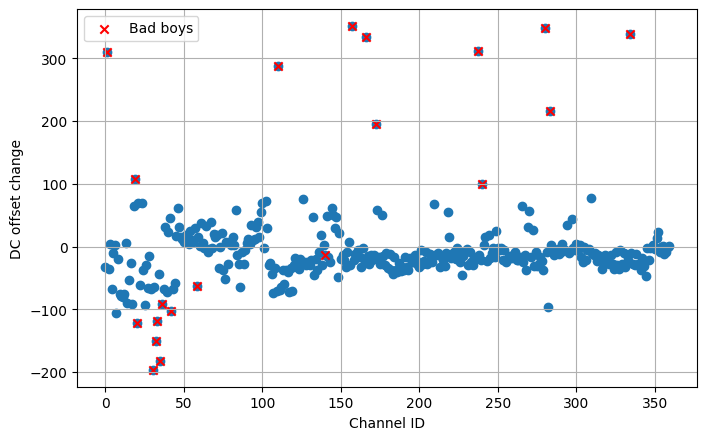

In [81]:
baddies = [1, 19, 20, 30, 32, 33, 35, 36, 42, 58, 110, 140, 157, 166, 172, 237, 240, 280, 283, 334]

fig = plt.figure(figsize=(8,5),dpi=100)
plt.scatter( old_nominal["channel_id"], old_nominal["DC_offset_new"]-old_nominal["DC_offset"])
plt.scatter( old_nominal[old_nominal["channel_id"].isin(baddies)]["channel_id"],
            old_nominal[old_nominal["channel_id"].isin(baddies)]["DC_offset_new"]-old_nominal[old_nominal["channel_id"].isin(baddies)]["DC_offset"],
           marker="x", color="red", label="Bad boys")

plt.xlabel("Channel ID")
plt.ylabel("DC offset change")
plt.grid()
plt.legend()
plt.show()

In [16]:
with_m20 = pd.read_csv("calibrations/DC_offsets_for_"+str(target)+"_TEST.csv",sep=",")
without_m20 = pd.read_csv("calibrations/DC_offsets_for_"+str(target)+"_24Oct2023_calibrated.csv",sep=",")

with_m20.rename(columns={'baseline':"baseline_m20", "DC_offset":"DC_offset_m20"}, inplace=True)
without_m20 = (without_m20.join( with_m20, on=["channel_id"], rsuffix="_new", how='inner'))

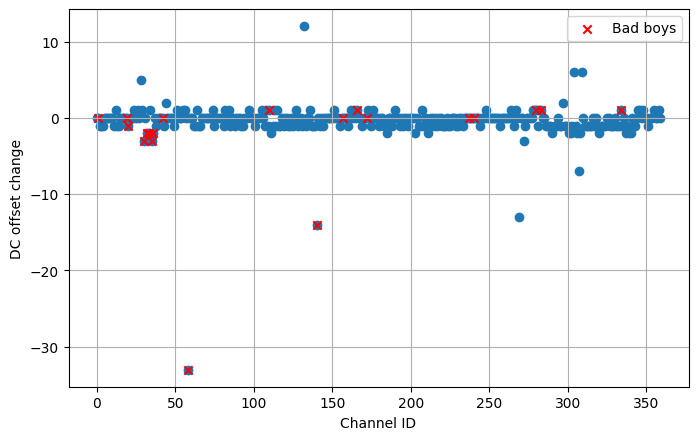

In [17]:
baddies = [1, 19, 20, 30, 32, 33, 35, 36, 42, 58, 110, 140, 157, 166, 172, 237, 240, 280, 283, 334]

fig = plt.figure(figsize=(8,5),dpi=100)
plt.scatter( without_m20["channel_id"], without_m20["DC_offset_m20"]-without_m20["DC_offset"])
plt.scatter( without_m20[without_m20["channel_id"].isin(baddies)]["channel_id"],
            without_m20[without_m20["channel_id"].isin(baddies)]["DC_offset_m20"]-without_m20[without_m20["channel_id"].isin(baddies)]["DC_offset"],
           marker="x", color="red", label="Bad boys")

plt.xlabel("Channel ID")
plt.ylabel("DC offset change")
plt.grid()
plt.legend()
plt.show()

The difference between the two (including or not including m20) is small for basically all channels. Since errors look generally lower, including it is fine. However, I already created the file without it so I'm not going to change that.